# MNIST-projekt för kunskapskontroll 2

Importera nödvändiga paket. Skapa funktion för att visa Confusion Matrix. *Detta är hämtat från boken*

In [7]:
# Paket för data och modellering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

# Funktionsdefinition
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    

Läs in data och ta en titt.

In [ ]:
# Läs in hela MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)




(70000, 784)
(70000,)


(70000, 784)
(70000,)
True label for the plotted image is  5


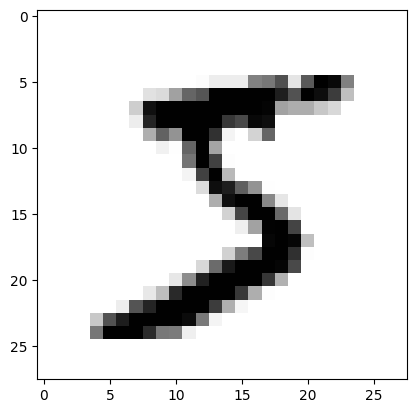

In [13]:
# Kolla på grejerna
print(X.shape)
print(y.shape)

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
print("True label for the plotted image is ", y[0])

# print(mnist.DESCR)
# jag kopierade in detta i en markdown för bättre läsbarhet.

The MNIST database of handwritten digits with 784 features, raw data available at:
http://yann.lecun.com/exdb/mnist/

It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples.

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20×20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28×28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28×28 field.

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications.

The MNIST database was constructed from NIST's. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found in the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students.

Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test set among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. The test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000-pattern training set contained examples from approximately 250 writers. The sets of writers of the training set and test set were made disjoint.

SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 are available and were used to unscramble the writers.

SD-1 was then split in two: characters written by the first 250 writers went into the new training set. The remaining 250 writers were placed in the new test set. Thus there were two sets with nearly 30,000 examples each.

The new training set was completed with enough examples from SD-3, starting at pattern #0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern #35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000-sample training set is available.

Downloaded from openml.org.

## Splitting time!
Eftersom jag nu är äldre och visare än när jag lämnade in förra uppgiften så börjar jag direkt att dela upp data.  

In [ ]:
# Dela först upp så att jag får 10000 testrader
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=10000, 
    random_state=42
)

# Ta sedan ut 10000 valideringsrader
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=10000, 
    random_state=42
)


Vi skalar data. 

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Testar att träna tre modeller och kombinera i en voting classifier. 

In [ ]:
logreg_clf = LogisticRegression(max_iter=1000)
random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
extra_trees_clf = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42
)

named_estimators = [
    ("logreg_clf", logreg_clf),
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
]

voting_clf = VotingClassifier(named_estimators, voting="hard")

models = [logreg_clf, random_forest_clf, extra_trees_clf, voting_clf]
for model in models:
    model.fit(X_train, y_train)

print("Accuracy for each model")
model_names = ["Logistic Regression", "Random Forest", "Extra Trees", "Voting Classifier"]
for name, model in zip(model_names, models):
    score = model.score(X_val, y_val)
    print(f"{name:20s}: {score:.4f}")

I datasetet är bilderna lagrade med gråskalevärden 0-255. 
Att döma av dokumentationen är det bättre att normalisera detta till 0-1 för bättre träning 
(siffrorna är små och har ungefär samma storleksordning).

In [ ]:
# Skala pixlar till 0–1 (float istf uint8)
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0


Dags att se hur det ser ut. 